<p style="font-size:14px; text-align: right">CoastWatch Python Exercises</p>  

# Extracting Satellite Data within an Irregular Boundary from ERRDAP
> history | updated August 2021  
> owner | NOAA CoastWatch

## In this exercise, you will use Python to download data from ERDDAP using an irregular boundary.

### The exercise demonstrates the following skills: 

* Using Python to retrieve information about a dataset from ERDDAP
* Getting boundary data from a local CSV file
* Downloading satellite data from ERDDAP in netCDF format
* Extracting data within an irregular boundary with Python

*The scripts in this exercise are written in Python 3.7.*    

## Get set up

### Look for python modules you might not have installed
We will be using the xarray, numpy, and pandas modules for this exercise. Make sure that they are installed in your Python 3 environment. 
* A quick way to do this is with the script below
* If you find missing modules, please go to the appendix at the bottom of the page for installation instructions.

In [39]:
import pkg_resources

# Create a set 'curly brackets' of the modules to look for
# You can put any modules that you want to in the set
required = {'xarray', 'numpy', 'pandas','shapely'}

# look for the installed packages
installed = {pkg.key for pkg in pkg_resources.working_set}

# Find which modules are missing
missing = required - installed
if len(missing)==0:
    print('All modules are installed')
else:
    print('These modules are missing:', ', '.join(missing))

These modules are missing: shapely


###  Import the modules

In [40]:
import numpy as np  # for matrix operations
import numpy.ma as ma  # for masking arrays
import pandas as pd  # for tabular data
import xarray as xr  # for gridded data
import shapely

## Extract data from an irregular bounding box
Extract a timeseries of environmental data from an ERDDAP server within an irregular geographical bounding box (polygon), e.g. the boundaries of marine protected area. This is similar to the R rerddap-Xtractogon function

The example uses a polygon that outlines the Monterey Bay Marine Protected Area.  

* **Load a csv file (shelf_boundary_gom.csv) that defines the polygon's latitude and longitude coordinates**   
The polygon is a series of longitude and latitude coordinates. If you connect the coordinate pairs, like a dot-to-dot puzzle, you create an outline of the Monterey Bay Marine Protected Area.

In [30]:
# Load CSV into Pandas
myPolygon = pd.read_csv('../shapes/mbnms.csv')

# list the first 5 values as an example
myPolygon.head()

,Longitude,Latitude
0,-122.6275,37.88108
1,-122.6273,37.88096
2,-122.6269,37.88097
3,-122.6265,37.88077
4,-122.6260,37.88077


## Create a shape from the polygon using the "shapely" module

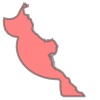

In [31]:
import shapely.vectorized
from shapely.geometry import Polygon

# Reform the csv data into lon, lat pairs
poly = list(zip(list(myPolygon.Longitude), list(myPolygon.Latitude)))

# create shape
polyshape = Polygon(poly)
polyshape

## Load the satellite  SST data from ERDDAP 
* See detailed explanation of these functions in tutorial #1
* The satellite dataset used in this example is nesdisGeoPolarSSTN5SQNRT a low resolution data product with small file size that lends itself well to courses and bandwidth restricted situations


In [32]:
def point_to_dataset(dataset_id, base_url='https://coastwatch.pfeg.noaa.gov/erddap/griddap'):
    base_url = base_url.rstrip('/')
    full_url = '/'.join([base_url, dataset_id])
    return xr.open_dataset(full_url)

def get_data(my_da, my_var,
             my_lt_min, my_lt_max, 
             my_ln_min, my_ln_max, 
             my_tm_min, my_tm_max
            ):
    
    my_data = my_da[my_var].sel(
                                latitude=slice(my_lt_min, my_lt_max), 
                                longitude=slice(my_ln_min, my_ln_max), 
                                time=slice(my_tm_min, my_tm_max)
                               )
    return my_data

In [33]:
da = point_to_dataset('nesdisGeoPolarSSTN5SQNRT')

# uncomment the "da" below to see the full data array info
da

<xarray.Dataset>
Dimensions:           (latitude: 3600, longitude: 7200, time: 6914)
Coordinates:
  * time              (time) object 2002-09-01 12:00:00 ... 2021-08-12 12:00:00
  * latitude          (latitude) float32 -89.97 -89.93 -89.88 ... 89.93 89.97
  * longitude         (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    analysed_sst      (time, latitude, longitude) float32 ...
    analysis_error    (time, latitude, longitude) float32 ...
    sea_ice_fraction  (time, latitude, longitude) float32 ...
    mask              (time, latitude, longitude) float32 ...
Attributes: (12/50)
    acknowledgement:            NOAA/NESDIS
    cdm_data_type:              Grid
    comment:                    The Geo-Polar Blended Sea Surface Temperature...
    Conventions:                CF-1.6, Unidata Observation Dataset v1.0, COA...
    creator_email:              john.sapper@noaa.gov
    creator_name:               Office of Satellite Products and Operations
    ...                         ...
    summary:                    This dataset is an aggregation of Science Qua...
    testOutOfDate:              now-17days
    time_coverage_end:          2021-08-12T12:00:00Z
    time_coverage_start:        2002-09-01T12:00:00Z
    title:                      SST, NOAA Geo-Polar Blended Global Level 4, S...
    Westernmost_Easting:        -179.975

### Get satellite data with our geographical and time ranges

In [34]:
lat_min  = 32.
lat_max = 39.
lon_min = -124.
lon_max = -117.
time_min = '2020-06-03T12:00:00'  # written in ISO format
time_max = '2020-06-07T12:00:00'  # written in ISO format
my_var = 'analysed_sst'

sst = get_data(
               da, my_var,
               lat_min, lat_max,
               lon_min, lon_max,
               time_min, time_max
              )

# the sst data array is a subset if da
print(sst.dims)
print('dimension size', sst.shape)

# uncomment the "sst" below to see the full data array info
#sst

('time', 'latitude', 'longitude')
dimension size (5, 140, 140)


### Create a mask from the polygon object
* Make a copy of the SST data array
* Turn the array into a mask layer by finding all pixels that are inside the polygon. Give these pixels a value of True. Cells outside the polygon have a value of False.
* Plot the mask on a map to see its location.

In [35]:
# Flatten and make a list of lon/lat pairs. 
# Make 2D grids of the lat and lon vectors
p_lons, p_lats = np.meshgrid(sst.longitude, sst.latitude)

mask = shapely.vectorized.contains(polyshape,  p_lons, p_lats)

<ipython-input-35-c6028778f62e>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = shapely.vectorized.contains(polyshape,  p_lons, p_lats)


### Create a masked version of the sst data area 
* Data outside of the Monterey Bay National Marine Sanctuary will be masked out
* Plot the masked SST (SST within the shapefile boundary)

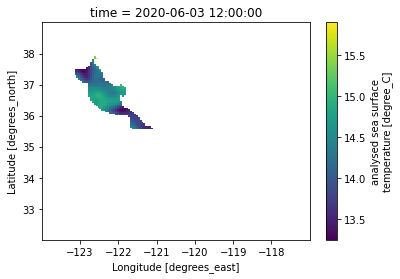

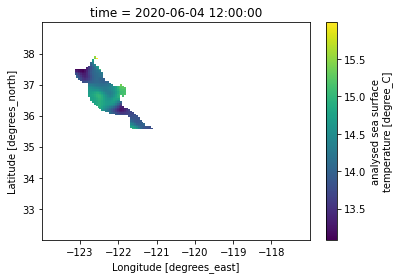

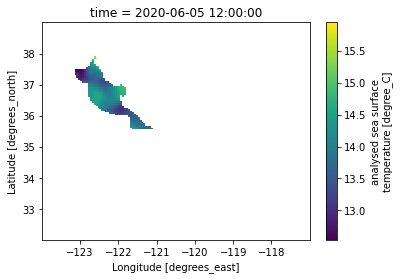

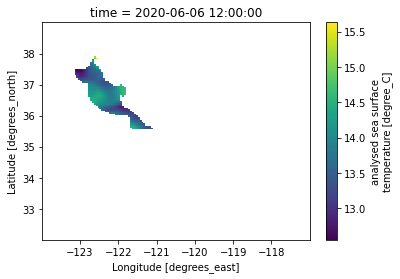

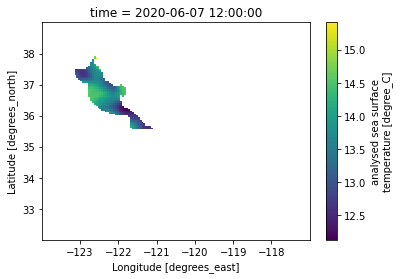

In [36]:
import matplotlib.pyplot as plt

# Copy the sst data array
sst_masked = sst.copy(deep=True, data=None)

# Apply the mask to each time slice
for i in range(0, len(sst_masked.time)):
    sst_masked[i,:,:] = sst_masked.isel(time=i).where(mask == 1)

#Plot the results for each time slice
for i in range(0,len(sst_masked.time)):
    ax = plt.subplot()
    sst_masked.isel(time=i).plot.imshow()
    plt.show()

### Create a new data frame and compute basic statistics for the area within the boundary 


In [37]:
# create the data frame
masked_sst_df = pd.DataFrame()

# add the data
masked_sst_df["date"] = sst_masked.time
masked_sst_df["mean"] = sst_masked.mean(axis=(1,2))
masked_sst_df["stdev"] = sst_masked.std(axis=(1,2)) 
masked_sst_df["n"] = sst_masked.count(axis=(1,2)) 

# Display
display(masked_sst_df)

# uncomment to save the data
# masked_sst_df.to_csv('mbnms_results.csv', index = False)

,date,mean,stdev,n
0,2020-06-03 12:00:00,14.259453,0.470414,554
1,2020-06-04 12:00:00,14.243837,0.517960,554
2,2020-06-05 12:00:00,13.877666,0.536191,554
3,2020-06-06 12:00:00,13.717341,0.478556,554
4,2020-06-07 12:00:00,13.524508,0.616973,554


### Plot the mean SST within the boundary over time

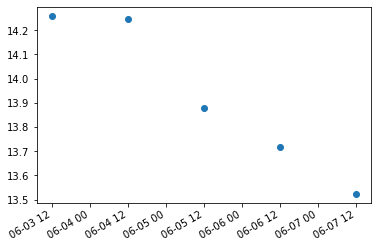

In [38]:
plt.plot_date(sst_masked.time, masked_sst_df["mean"], 'o')
plt.gcf().autofmt_xdate()


## Appendix

### Module Installation instructions:

pandas: https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html   

numpy: https://numpy.org/install/  

xarray: http://xarray.pydata.org/en/latest/getting-started-guide/installing.html

shapely: conda install shapely OR pip install --user shapely    in Anaconda powershell